In [6]:
import os
from pathlib import Path

# Set working directory to the base directory 'gpudrive_madrona'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive_madrona' not found")
os.chdir(working_dir)
import torch
from PIL import Image
import seaborn as sns
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.env.config import EnvConfig, RenderConfig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.visualize.utils import img_from_fig

sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (10, 5)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")
mpl.rcParams["lines.markersize"] = 8

plt.set_loglevel("WARNING")
%matplotlib inline


## Settings

In [7]:
# Guidance
GUIDANCE_MODE = "log_replay"
GUIDANCE_DROPOUT = 0.9999
GUIDANCE_DROPOUT_MODE = "end_points_only"

# Data
DATASET = "data/processed/wosac/validation_json_1"
FIGURES_DIR = "examples/eval/figures"
DATA_FOLDER = "examples/eval/figures_data/"

## Make env

In [8]:
env_config = EnvConfig(
    reward_type="guided_autonomy",
    guidance=True,
    guidance_mode=GUIDANCE_MODE,
    add_reference_heading=True,
    add_reference_speed=True,
    add_reference_pos_xy=True,
    init_mode="wosac_train",
    smoothen_trajectory=False,
    dynamics_model="delta_local",
    guidance_dropout_prob=GUIDANCE_DROPOUT,
    guidance_dropout_mode=GUIDANCE_DROPOUT_MODE,
    init_steps=0,
)
render_config = RenderConfig()

train_loader = SceneDataLoader(
    root=DATASET,
    batch_size=2,
    dataset_size=100,
    sample_with_replacement=True,
    shuffle=True,
    file_prefix="",
    
)

env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=32, 
    device="cpu",
)

obs = env.reset(env.cont_agent_mask)
expert_actions, _, _, _ = env.get_expert_actions()

In [42]:
for time_step in range(env.init_steps, 10):
    print(f"Step: {env.step_in_world[0, 0, 0].item()}")

    # Step the environment
    expert_actions, _, _, _ = env.get_expert_actions()
    env.step_dynamics(expert_actions[:, :, time_step, :])

    obs = env.get_obs(env.cont_agent_mask)
    rew = env.get_rewards()
    

# Part of the obs with guidance
# (agents, time, features)
env.guidance_obs_norm.shape

Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14


torch.Size([12, 91, 4])

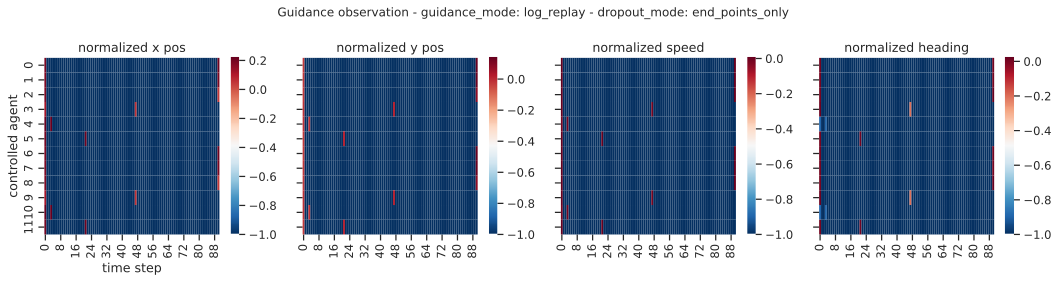

In [43]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True)

fig.suptitle(
    f"Guidance observation - guidance_mode: {GUIDANCE_MODE} - dropout_mode: {GUIDANCE_DROPOUT_MODE}",
    fontsize=12,
    #y=1.1,
)

axs[0].set_title("normalized x pos")
sns.heatmap(env.guidance_obs_norm[:, :, 0].numpy(), cmap="RdBu_r", cbar=True, ax=axs[0])

axs[1].set_title("normalized y pos")
sns.heatmap(env.guidance_obs_norm[:, :, 1].numpy(), cmap="RdBu_r", cbar=True, ax=axs[1])

axs[2].set_title("normalized speed")
sns.heatmap(env.guidance_obs_norm[:, :, 2].numpy(), cmap="RdBu_r", cbar=True, ax=axs[2])

axs[3].set_title("normalized heading")
sns.heatmap(env.guidance_obs_norm[:, :, 3].numpy(), cmap="RdBu_r", cbar=True, ax=axs[3]);

axs[0].set_xlabel("time step")
axs[0].set_ylabel("controlled agent")
plt.tight_layout()